## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [1]:
import numpy as np

In [2]:
timesteps = 100   # number of timesteps in the input sequence
input_features = 32   # dimensionally of the input feature space
output_features = 64  # dimensionally of the output feature space

In [3]:
# Input data: random noise for the sake of the example
inputs = np.random.random((timesteps, input_features))

In [4]:
# Initial state: an all-zero vector
state_t = np.zeros((output_features))

In [5]:
# Create random weight matrices
W = np.random.random((output_features,input_features))
U = np.random.random((output_features,output_features))
b = np.random.random((output_features))

In [ ]:
successive_outputs = []
for input_t in inputs:  # input_t is a vector of shape (input_features)
  output_t = np.tanh(np.dot(W,input_t) + np.dot(U,state_t)+b) # combines the
                                              # input with the current state to
                                              # obtain the current output
  successive_outputs.append(output_t)   # stores this output in a list
  state_t = output_t   # updates the state of the network for the next tiemstep
# The final output is a 2D tensor of shape (timesteps, output_features)
final_output_sequence = np.stack(successive_outputs, axis=0)
# let's check the shape of the final output before concatenating
np.shape(successive_outputs)

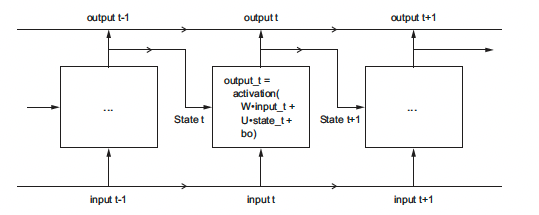

## A recurrent layer in Keras

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = tf.keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## A temperature-forecasting example

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

**Inspecting the data of Jena weather dataset**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Ploting the temperature timeseries**

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Ploting the first 10 days of the temperature timeseries**

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

### Preparing the data

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

**A simple LSTM-based model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")